In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import networkx as nx
from grove.pyqaoa.qaoa import QAOA
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.gates import H
from pyquil.api import QVMConnection as q_sim
import pyquil.quil as pq

In [4]:
# n-qubit graph
n = 6
graph = nx.Graph()
for i in range(n):
    graph.add_edge(i, (i + 1) % n)

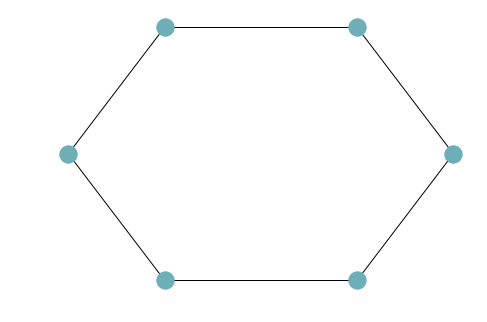

In [5]:
nx.draw_circular(graph, node_color="#6CAFB7")

## Simple Bipartite Graph

```
u   v
|\ /|    1  3  5
| • |    v––x––z
|/ \|     \/ \/
w   x     /\ /\
|\ /|    u––w––y
| • |    0  2  4
|/ \|
y   z
```

In [265]:
display_options = {'node_color' :"#6CAFB7",
                   'node_size'  :250,
                   'with_labels': True}

In [13]:
g = nx.Graph()

nodes = [""]

g.add_nodes_from("uvwxyz")

In [14]:
g.nodes()

NodeView(('u', 'v', 'w', 'x', 'y', 'z'))

In [45]:
edges = [('u','x'),('u','w'),('v','w'),('v','x'),
         ('y','w'),('y','x'),('z','w'),('z','x')]
g.add_edges_from(edges)

In [47]:
g.edges()

EdgeView([('u', 'x'), ('u', 'w'), ('v', 'w'), ('v', 'x'), ('w', 'y'), ('w', 'z'), ('x', 'y'), ('x', 'z')])

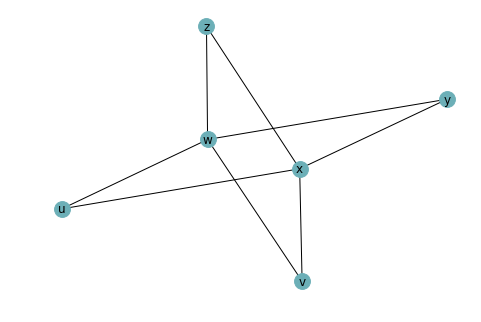

In [46]:
nx.draw(g, with_labels=True, **display_options)

## 'Classical' Max-Cut Solver

I'll use this to test my 'quantum' solutions later. No attempts at efficiency, just a brute-force check.

Constraints:

- $V_1 \cap V_2 = \varnothing$ and $V_1 \cup V_2 = V$; $\,\,\,\,V: graph$

- cuts A,B have no internal edges
- no edge has more than 1 end-point

<img src="images/max_cut_bipartite_graph_notes.png" style="width:100%">

I'll start by assuming the graph is bipartite and focus on finding the max cut.

In [50]:
g.edges

EdgeView([('u', 'x'), ('u', 'w'), ('v', 'w'), ('v', 'x'), ('w', 'y'), ('w', 'z'), ('x', 'y'), ('x', 'z')])

In [60]:
g.nodes

NodeView(('u', 'v', 'w', 'x', 'y', 'z'))

In [61]:
def internal_edge(edge, graph):
    """Checks if edge is internal to graph."""
    return edge in graph.edges

In [70]:
list(g.edges())

[('u', 'x'),
 ('u', 'w'),
 ('v', 'w'),
 ('v', 'x'),
 ('w', 'y'),
 ('w', 'z'),
 ('x', 'y'),
 ('x', 'z')]

In [71]:
edge = list(g.edges())[0];
edge

('u', 'x')

In [72]:
internal_edge(edge, g)

True

In [96]:
def single_endpoint(edge, graph):
    """Checks that an edge has a single endpoint in graph."""
    return list(graph.edges()).count(edge) == 1

In [97]:
for edge in list(g.edges()):
    print(single_endpoint(edge, g))

True
True
True
True
True
True
True
True


What has to be maximized is the number of edges crossed by the cut.

In [99]:
g.edges()

EdgeView([('u', 'x'), ('u', 'w'), ('v', 'w'), ('v', 'x'), ('w', 'y'), ('w', 'z'), ('x', 'y'), ('x', 'z')])

In [147]:
a = g.edges()
b = g.edges()

In [152]:
for val in a.values():
    if val in b.values():
        print(1)

1
1
1
1
1
1
1
1


In [167]:
list(g.neighbors('u'))

['x', 'w']

In [163]:
tmp = g['u'];tmp

AtlasView({'x': {}, 'w': {}})

In [164]:
tmp.values()

ValuesView(AtlasView({'x': {}, 'w': {}}))

In [157]:
list(g.edges())

[('u', 'x'),
 ('u', 'w'),
 ('v', 'w'),
 ('v', 'x'),
 ('w', 'y'),
 ('w', 'z'),
 ('x', 'y'),
 ('x', 'z')]

In [278]:
# def edges_between(graph_A, graph_B):
#     """Gets the number of edges shared by edges_A and edges_B."""
#     count = 0
#     for edge in graph_A.edges:
#         count += edge in graph_B.edges
#     return count

def edges_between(edges_A, edges_B):
    """Gets the number of edges shared by edges_A and edges_B."""
    count = 0
    for edge in edges_A:
        count += set(edge) in map(set, edges_B)
    return count

In [279]:
def get_edges_from_nodes(nodes, graph):
    """Retreives all edges connected to nodes in graph."""
    edges = []
    for node in nodes:
        for edge in graph.edges:
            if node in edge:
                edges.append(edge)
    return edges

In [354]:
def get_unique_permutations(nodes, split_idx):
    """Returns all unique combinations of nodes split at split_idx."""
    nodes_A,nodes_B = [],[]
    # get all unique combos up to the split
    for perm in itertools.permutations(nodes, split_idx+1):
        if set(perm) not in nodes_A: nodes_A.append(set(perm))
    # cast the sets back to lists
    nodes_A = list(map(list, nodes_A))
    # get all unique combos after the split
    for perm in nodes_A:
        add_nodes = nodes.copy()
        for node in perm: 
            add_nodes.remove(node)
        nodes_B.append(add_nodes)
    # return permutations of split pairs
    return nodes_A, nodes_B

Manual run; The answer should be 8

In [285]:
# Select Cut
nodes_A = ['w','x']
nodes_B = ['u','v','y','z']

# Get Edges of Cut
edges_A = get_edges_from_nodes(nodes_A, g)
edges_B = get_edges_from_nodes(nodes_B, g)

# Check No Internal Edges
A_internal = g.copy()
A_internal.remove_nodes_from(nodes_B)
B_internal = g.copy()
B_internal.remove_nodes_from(nodes_A)
for graph in (A_internal, B_internal): assert(len(graph.edges)==0)

# Check all Single Endpoints  –  check first no internals
assert(set(edges_B)==set(edges_A))
    
# Count Crossed Edges
print(edges_between(edges_A, edges_B))

8


Now to iterate through all possible cuts:

In [377]:
# create graph
g = nx.Graph()
g.add_nodes_from("uvwxyz")
edges = [('u','x'),('u','w'),('v','w'),('v','x'),
         ('y','w'),('y','x'),('z','w'),('z','x')]
g.add_edges_from(edges)

max_crossed = 0

# get cut splits
n_nodes = len(g.nodes)
split_idxs = list(range(0, int(n_nodes//2)))

# iterate through all unique cut sizes
for split_idx in split_idxs:
    permutations = get_unique_permutations(nodes, split_idx)
    
    # iterate through all unique node permutations (Select Cut)
    for nodes_A, nodes_B in list(zip(*permutations)):
        print(nodes_A, nodes_B)
        
        # get edges of cut
        edges_A = get_edges_from_nodes(nodes_A, g)
        edges_B = get_edges_from_nodes(nodes_B, g)
        
        # check no internal edges
        A_internal = g.copy()
        B_internal = g.copy()
        A_internal.remove_nodes_from(nodes_B)
        B_internal.remove_nodes_from(nodes_A)
        for graph in (A_internal, B_internal): 
            #assert(len(graph.edges)==0)
            internal_exists = False
            if len(graph.edges) > 0: 
                internal_exists = True
                break
        if internal_exists: continue
        
        # check all single endpoints – (check first no internals)
        #assert(set(edges_B)==set(edges_A))
        if set(edges_B) != set(edges_A): continue
        
        # count crossed edges
        count = edges_between(edges_A, edges_B)
        if count > max_crossed:
            max_crossed = count
            max_cut = [nodes_A, nodes_B]
            
print(max_crossed, max_cut)

['u'] ['v', 'w', 'x', 'y', 'z']
['v'] ['u', 'w', 'x', 'y', 'z']
['w'] ['u', 'v', 'x', 'y', 'z']
['x'] ['u', 'v', 'w', 'y', 'z']
['y'] ['u', 'v', 'w', 'x', 'z']
['z'] ['u', 'v', 'w', 'x', 'y']
['v', 'u'] ['w', 'x', 'y', 'z']
['w', 'u'] ['v', 'x', 'y', 'z']
['u', 'x'] ['v', 'w', 'y', 'z']
['u', 'y'] ['v', 'w', 'x', 'z']
['u', 'z'] ['v', 'w', 'x', 'y']
['v', 'w'] ['u', 'x', 'y', 'z']
['v', 'x'] ['u', 'w', 'y', 'z']
['v', 'y'] ['u', 'w', 'x', 'z']
['v', 'z'] ['u', 'w', 'x', 'y']
['w', 'x'] ['u', 'v', 'y', 'z']
['w', 'y'] ['u', 'v', 'x', 'z']
['w', 'z'] ['u', 'v', 'x', 'y']
['x', 'y'] ['u', 'v', 'w', 'z']
['x', 'z'] ['u', 'v', 'w', 'y']
['z', 'y'] ['u', 'v', 'w', 'x']
['v', 'u', 'w'] ['x', 'y', 'z']
['v', 'u', 'x'] ['w', 'y', 'z']
['v', 'u', 'y'] ['w', 'x', 'z']
['v', 'u', 'z'] ['w', 'x', 'y']
['w', 'u', 'x'] ['v', 'y', 'z']
['w', 'u', 'y'] ['v', 'x', 'z']
['w', 'u', 'z'] ['v', 'x', 'y']
['u', 'x', 'y'] ['v', 'w', 'z']
['u', 'x', 'z'] ['v', 'w', 'y']
['u', 'z', 'y'] ['v', 'w', 'x']
['v', 'x

Refactored:

In [381]:
def valid_cut(nodes_AB, edges_AB, graph):
    """Determines if a cut is valid."""
    
    nodes_A, nodes_B = nodes_AB
    edges_A, edges_B = edges_AB
    valid_cut = True
    
    # get edges of cut
    edges_A = get_edges_from_nodes(nodes_A, graph)
    edges_B = get_edges_from_nodes(nodes_B, graph)

    # check no internal edges
    A_internal = graph.copy()
    B_internal = graph.copy()
    A_internal.remove_nodes_from(nodes_B)
    B_internal.remove_nodes_from(nodes_A)
    
    for graph in (A_internal, B_internal): 
        if len(graph.edges) > 0: 
            valid_cut = False
            break

    # check all single endpoints – (check first no internals)
    if valid_cut: valid_cut = set(edges_B)==set(edges_A)
        
    return valid_cut

In [383]:
def find_max_cut(graph):
    """Finds the Max Cut of a Bipartite Graph."""
    max_crossed = 0

    # get cut splits
    n_nodes = len(graph.nodes)
    split_idxs = list(range(0, int(n_nodes//2)))

    # iterate through all unique cut sizes
    for split_idx in split_idxs:
        permutations = get_unique_permutations(nodes, split_idx)

        # iterate through all unique node permutations (Select Cut)
        for nodes_A, nodes_B in list(zip(*permutations)):

            # get edges of cut
            edges_A = get_edges_from_nodes(nodes_A, graph)
            edges_B = get_edges_from_nodes(nodes_B, graph)

            # check no internal edges and check all single endpoints
            if not valid_cut((nodes_A, nodes_B), (edges_A, edges_B), graph):
                continue

            # count crossed edges
            count = edges_between(edges_A, edges_B)
            if count > max_crossed:
                max_crossed = count
                max_cut = [nodes_A, nodes_B]
                
    # check max cut exists
    if max_crossed == 0:
        max_cut = [None, None]
    
    return max_crossed, max_cut

8 [['w', 'x'], ['u', 'v', 'y', 'z']]


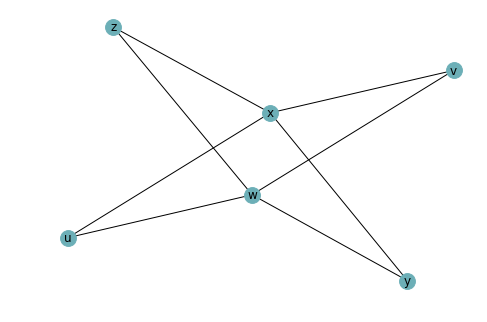

In [387]:
# create graph
g = nx.Graph()
g.add_nodes_from("uvwxyz")
edges = [('u','x'),('u','w'),('v','w'),('v','x'),
         ('y','w'),('y','x'),('z','w'),('z','x')]
g.add_edges_from(edges)

# find max cut
max_crossed, max_cut = find_max_cut(g)

# display
print(f"{max_crossed} {max_cut}")
nx.draw(g, **display_options)

## More scrap work

In [370]:
split_idxs

[0, 1, 2]

In [362]:
max_crossed

0

In [356]:
permutations = get_unique_permutations(nodes, 1)
list(zip(*permutations))

[(['v', 'u'], ['w', 'x', 'y', 'z']),
 (['w', 'u'], ['v', 'x', 'y', 'z']),
 (['u', 'x'], ['v', 'w', 'y', 'z']),
 (['u', 'y'], ['v', 'w', 'x', 'z']),
 (['u', 'z'], ['v', 'w', 'x', 'y']),
 (['v', 'w'], ['u', 'x', 'y', 'z']),
 (['v', 'x'], ['u', 'w', 'y', 'z']),
 (['v', 'y'], ['u', 'w', 'x', 'z']),
 (['v', 'z'], ['u', 'w', 'x', 'y']),
 (['w', 'x'], ['u', 'v', 'y', 'z']),
 (['w', 'y'], ['u', 'v', 'x', 'z']),
 (['w', 'z'], ['u', 'v', 'x', 'y']),
 (['x', 'y'], ['u', 'v', 'w', 'z']),
 (['x', 'z'], ['u', 'v', 'w', 'y']),
 (['z', 'y'], ['u', 'v', 'w', 'x'])]

In [357]:
for a,b in list(zip(*permutations)):
    print(a, b)

['v', 'u'] ['w', 'x', 'y', 'z']
['w', 'u'] ['v', 'x', 'y', 'z']
['u', 'x'] ['v', 'w', 'y', 'z']
['u', 'y'] ['v', 'w', 'x', 'z']
['u', 'z'] ['v', 'w', 'x', 'y']
['v', 'w'] ['u', 'x', 'y', 'z']
['v', 'x'] ['u', 'w', 'y', 'z']
['v', 'y'] ['u', 'w', 'x', 'z']
['v', 'z'] ['u', 'w', 'x', 'y']
['w', 'x'] ['u', 'v', 'y', 'z']
['w', 'y'] ['u', 'v', 'x', 'z']
['w', 'z'] ['u', 'v', 'x', 'y']
['x', 'y'] ['u', 'v', 'w', 'z']
['x', 'z'] ['u', 'v', 'w', 'y']
['z', 'y'] ['u', 'v', 'w', 'x']


---

In [324]:
nodes = ['u', 'v', 'w', 'x', 'y', 'z']; nodes

['u', 'v', 'w', 'x', 'y', 'z']

In [326]:
nodes_A = ['w', 'x']

In [329]:
nodes.remove(nodes_A)

TypeError: remove() takes exactly one argument (2 given)

Checking permutation logic

In [304]:
len(list(itertools.permutations(nodes, 2)))

30

In [308]:
permutations = []
for perm in itertools.permutations(nodes, 2):
    if set(perm) not in permutations: permutations.append(set(perm))
len(permutations)

15

In [319]:
len(list(itertools.permutations(nodes, 4)))

360

In [320]:
permutations = []
for perm in itertools.permutations(nodes, 4):
    if set(perm) not in permutations: permutations.append(set(perm))
len(permutations)

15

In [311]:
permutations

[{'u', 'v', 'w', 'x'},
 {'u', 'v', 'w', 'y'},
 {'u', 'v', 'w', 'z'},
 {'u', 'v', 'x', 'y'},
 {'u', 'v', 'x', 'z'},
 {'u', 'v', 'y', 'z'},
 {'u', 'w', 'x', 'y'},
 {'u', 'w', 'x', 'z'},
 {'u', 'w', 'y', 'z'},
 {'u', 'x', 'y', 'z'},
 {'v', 'w', 'x', 'y'},
 {'v', 'w', 'x', 'z'},
 {'v', 'w', 'y', 'z'},
 {'v', 'x', 'y', 'z'},
 {'w', 'x', 'y', 'z'}]

In [312]:
len(list(itertools.permutations(nodes, 6)))

720

In [316]:
permutations = []
for perm in itertools.permutations(nodes, 6):
    if set(perm) not in permutations: permutations.append(set(perm))
len(permutations)

1

In [321]:
permutations = []
for perm in itertools.permutations(nodes, 5):
    if set(perm) not in permutations: permutations.append(set(perm))
len(permutations)

6

In [322]:
permutations = []
for perm in itertools.permutations(nodes, 1):
    if set(perm) not in permutations: permutations.append(set(perm))
len(permutations)

6

In [314]:
len(list(itertools.permutations(nodes)))

720

In [315]:
nodes

['u', 'v', 'w', 'x', 'y', 'z']

In [282]:
edges_B

[('u', 'x'),
 ('u', 'w'),
 ('v', 'w'),
 ('v', 'x'),
 ('w', 'y'),
 ('x', 'y'),
 ('w', 'z'),
 ('x', 'z')]

In [281]:
edges_A

[('u', 'w'),
 ('v', 'w'),
 ('w', 'y'),
 ('w', 'z'),
 ('u', 'x'),
 ('v', 'x'),
 ('x', 'y'),
 ('x', 'z')]

(NodeView(('v', 'w', 'x', 'y', 'z')),
 EdgeView([('v', 'w'), ('v', 'x'), ('w', 'y'), ('w', 'z'), ('x', 'y'), ('x', 'z')]),
 None)

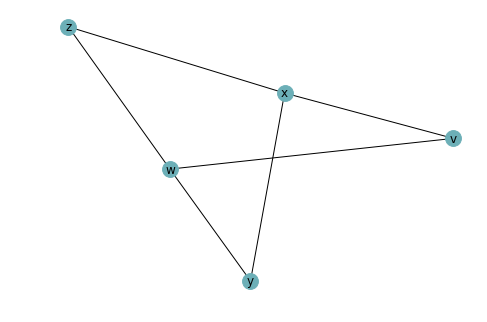

In [266]:
a = g.copy()
a.remove_node('u')
a.nodes, a.edges, nx.draw(a, **display_options)

---

In [246]:
g.nodes

NodeView(('u', 'v', 'w', 'x', 'y', 'z'))

In [247]:
map(set, itertools.permutations([1,2])

{(1, 2), (2, 1)}

In [236]:
num_nodes = len(g.nodes)
split_idxs = list(range(1, int(len(g.nodes)//2)))
for split_idx in split_idxs:
    nodes_A = 

In [237]:
split_idxs

[1, 2]

In [239]:

list(g.nodes)[1:]

['v', 'w', 'x', 'y', 'z', 'u"']

In [ ]:
# def edges_between(edges_A, edges_B):
#     """Gets the number of edges shared by edges_A and edges_B."""
#     count = 0
#     for edge in edges_A:
#         count += set(edge) in map(lambda x: set(x), edges_B)
#     return count

---

In [220]:
a = ("x", "v")
b = ("v", "x")

set(a) == set(b)

True

In [221]:
B = (b, ('z','w')); B

(('v', 'x'), ('z', 'w'))

In [224]:
set(a) in map(lambda x: set(x), B)

False

In [ ]:
#     count = 0
#     for edge in edges_A.values():
#         if edge in b.values():
#             count += 1
#     return count

---

In [205]:
g.edges

EdgeView([('u', 'x'), ('u', 'w'), ('v', 'w'), ('v', 'x'), ('w', 'y'), ('w', 'z'), ('x', 'y'), ('x', 'z')])

In [204]:
g.nodes

NodeView(('u', 'v', 'w', 'x', 'y', 'z', 'u"'))

In [217]:
nodes = ['u','x']
edges = []
for node in nodes:
    for edge in g.edges:
        if node in edge:
            edges.append(edge)
edges

[('u', 'x'), ('u', 'w'), ('u', 'x'), ('v', 'x'), ('x', 'y'), ('x', 'z')]

---

In [214]:
node = 'u'

edges = []
for edge in g.edges:
    if node in edge:
        edges.append(edge)
        
edges

[('u', 'x'), ('u', 'w')]

In [215]:
type(edges)

list

---

In [136]:
g['u']

AtlasView({'x': {}, 'w': {}})

In [137]:
g.edges()

EdgeView([('u', 'x'), ('u', 'w'), ('v', 'w'), ('v', 'x'), ('w', 'y'), ('w', 'z'), ('x', 'y'), ('x', 'z')])

In [139]:
type(g.edges())

networkx.classes.reportviews.EdgeView

In [142]:
nx.classes.reportviews.EdgeView

networkx.classes.reportviews.EdgeView

In [143]:
edges

[('u', 'x'),
 ('u', 'w'),
 ('v', 'w'),
 ('v', 'x'),
 ('y', 'w'),
 ('y', 'x'),
 ('z', 'w'),
 ('z', 'x')]

In [145]:
edge = ('x','u')
print(edge in edges)
edges = g.edges()
print(edge in edges)

False
True


---

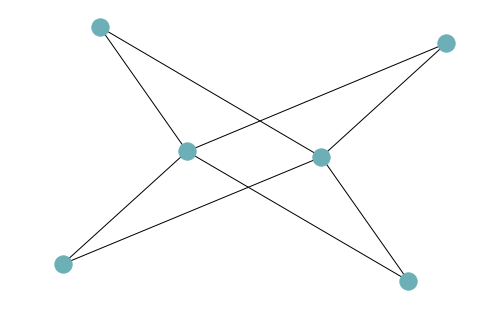

In [12]:
n = 6
color = "#6CAFB7"
graph = nx.Graph() # undirected graph

graph.add_edge(0, 2); graph.add_edge(0, 3)
graph.add_edge(1, 2); graph.add_edge(1, 3)

graph.add_edge(2, 0); graph.add_edge(2, 1); graph.add_edge(2, 4); graph.add_edge(2, 5)
graph.add_edge(3, 0); graph.add_edge(3, 1); graph.add_edge(3, 4); graph.add_edge(3, 5)

graph.add_edge(4, 2); graph.add_edge(4, 3)
graph.add_edge(5, 2); graph.add_edge(5, 3)

nx.draw_spring(graph, node_color=color)

In [ ]:
nx.bipartite.basic.